### This part of the code contains the code to load and preprocssing the dataset

In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import torchvision as tv

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

data = './dataset/inaturalist_12K' #This is the path to the dataset folder. I have kept inaturalist_12K folder inside a folder called dataset. 
trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform)
testset = ImageFolder(root=os.path.join(data, 'val'), transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(0.8 * len(trainset)) # I am keeping 80% of the actual training dataset for training and the remaining 20% will be for validation set.
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = ImageFolder(root=os.path.join(data, 'val'), transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = trainset.classes

print(f"Classes: {classes}")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Training samples: 7301
Validation samples: 1826
Test samples: 2000


### Question 1 (5 Marks)
Build a small CNN model consisting of $5$ convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer. 

After $5$ such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing $10$ neurons ($1$ for each of the $10$ classes). The input layer should be compatible with the images in the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip) dataset.

The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class ConvNN(nn.Module):
    def __init__(self,
                 m =[16, 32, 64, 128, 256],
                 k=[3, 3, 3, 3, 3],
                 pool_params=[{'kernel_size': 2, 'stride': 2}]*5,
                 activations=[F.relu]*5,
                 dense_neurons=512,
                 dense_activation=F.relu,
                 num_classes=10):
        super(ConvNN, self).__init__()

        self.activations = activations
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        in_channels = 3
        for i in range(5):
            self.conv_layers.append(
                nn.Conv2d(in_channels, m[i], kernel_size=k[i], padding=1)
            )
            in_channels = m[i]

            pool_config = pool_params[i]
            self.pool_layers.append(nn.MaxPool2d(**pool_config))

        sample_input, _ = next(iter(trainloader)) 
        sample_image = sample_input[0].unsqueeze(0)

        with torch.no_grad():
            x = sample_image
            for i in range(5):
                x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
            conv_output_shape = x.numel()

        self.fc1 = nn.Linear(conv_output_shape, dense_neurons)
        self.fc_out = nn.Linear(dense_neurons, num_classes)
        self.dense_activation = dense_activation

    def forward(self, x):
        for i in range(5):
            x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
        x = torch.flatten(x, 1)
        x = self.dense_activation(self.fc1(x))
        x = self.fc_out(x)
        return x




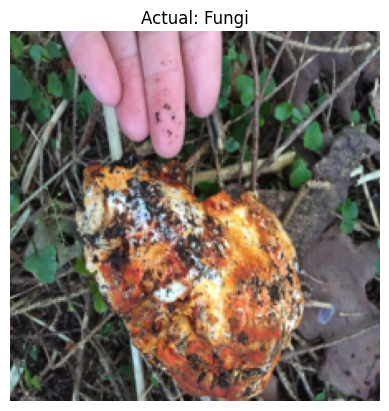

y   : Fungi
y': Arachnida


In [3]:
#The below piece of code contains the parameters of the 5 conv-activation-maxpool blocks and the dense layer.
model = ConvNN(
    m=[16, 32, 64, 128, 256], #Here we can customise the number of filters in each convolution layer. (ex: 1st convolution layer contains 16 filters and 2nd one has 32 and so on)
    k=[3, 3, 3, 3, 3], #Here we can customise the size of filters in each layer. I have kept all of them as 3X3 filters.
    pool_params=[
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 1st maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 2nd maxpooling layer
        {'kernel_size': 2, 'stride': 1}, #Filter size and Stride length for 3rd maxpooling layer 
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 4th maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 5th maxpooling layer
    ],
    dense_neurons=512,
    num_classes=10
)

#This code is for visualizing the output of the model's forward pass. The model is not yet trained, so the predictions are wrong. The training code is in the 2nd question's answer.
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(tv.utils.make_grid(images[0].unsqueeze(0)))
plt.title("Actual: " + classes[labels[0]])
plt.show()
model = ConvNN()
with torch.no_grad():
    outputs = model(images[0].unsqueeze(0))  # Add batch dimension
    _, predicted = torch.max(outputs, 1)

print(f"y   : {classes[labels[0]]}")
print(f"y': {classes[predicted[0]]}")

- What is the total number of computations done by your network? (assume $m$ filters in each layer of size $k\times k$  and $n$ neurons in the dense layer)

    Let the input images be N X N. Assuming m filters in each convolution layer, each filter is a k X k filter. Each convolution layer is followed by an activation and max pooling. There are 5 convolution layers, first layer maps from 3 channels (RGB) to m filters and the other 4 layers maps from m channels to m channels. We will assume the pooling layer also has the filter size of k X k. 

- What is the total number of parameters in your network? (assume $m$ filters in each layer of size $k\times k$ and $n$ neurons in the dense layer)



### Question 2 (15 Marks)
You will now train your model using the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip). The zip file contains a train and a test folder. Set aside $20\%$ of the training data, as validation data, for hyperparameter tuning. Make sure each class is equally represented in the validation data. **Do not use the test data for hyperparameter tuning.**

Using the sweep feature in wandb find the best hyperparameter configuration. Here are some suggestions but you are free to decide which hyperparameters you want to explore

- number of filters in each layer : $32$, $64$, ...
- activation function for the conv layers: ReLU, GELU, SiLU, Mish, ...
- filter organisation: same number of filters in all layers, doubling in each subsequent layer, halving in each subsequent layer, etc
- data augmentation: Yes, No
- batch normalisation: Yes, No
- dropout: $0.2$, $0.3$ (BTW, where will you add dropout? You should read up a bit on this)

Based on your sweep please paste the following plots which are automatically generated by wandb:
- accuracy v/s created plot (I would like to see the number of experiments you ran to get the best configuration). 
- parallel co-ordinates plot
- correlation summary table (to see the correlation of each hyperparameter with the loss/accuracy)

Also, write down the hyperparameters and their values that you sweeped over. Smart strategies to reduce the number of runs while still achieving a high accuracy would be appreciated. Write down any unique strategy that you tried.

In [4]:
import wandb
import torch.optim as opt

config_params = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [20, 25, 30]},
        'loss': {'values': ['cross_entropy']}, #can try with MSE as well, but for the answer, I am using only cross entropy loss as it is a classification task.
        'm': {'values': [32, 64, 128]}, #Number of filters in each layer
        'filter_org': {'values': ['same', 'double', 'half']},
        'optim_algo': {'values': ['sgd']},
        'batch_size': {'values': [1000, 1500, 2000]},
        'lr': {'values': [1e-2, 1e-3]},
        'data_aug': {'values': ['yes', 'no']},
        'batch_norm': {'values': ['yes', 'no']},
        'weight_init': {'values': ['random', 'xavier']},
        'dropout': {'values': [0.2, 0.3]},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},

}
}

activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish,
    'sigmoid': F.sigmoid
}

activation_module_map = {
    'relu': nn.ReLU,
    'gelu': nn.GELU,
    'silu': nn.SiLU,
    'mish': nn.Mish,
    'sigmoid': nn.Sigmoid
}

def init_weights(m, method):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if method == 'xavier':
            nn.init.xavier_uniform_(m.weight)
        else:
            nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def generate_filters(base_m, strategy):
    if strategy == 'same':
        return [base_m] * 5
    elif strategy == 'double':
        return [base_m * (2 ** i) for i in range(5)]
    elif strategy == 'half':
        return [max(1, base_m // (2 ** i)) for i in range(5)]
    

class ConvNNconfig(nn.Module):
    def __init__(self, m, k=[3, 3, 3, 3, 3], pool_params=None,
                 activation='relu', dense_neurons=512, dropout=0.0,
                 batch_norm=False, num_classes=10):
        super(ConvNNconfig, self).__init__()
        if pool_params is None:
            pool_params = [{'kernel_size': 2, 'stride': 2}] * 5

        act_fn = activation_map[activation]
        act_module = activation_module_map[activation]

        self.layers = nn.ModuleList()
        in_channels = 3

        for i in range(5):
            conv_block = [nn.Conv2d(in_channels, m[i], kernel_size=k[i], padding=1)]
            if batch_norm:
                conv_block.append(nn.BatchNorm2d(m[i]))
            conv_block.append(act_module())
            if dropout > 0:
                conv_block.append(nn.Dropout2d(dropout))
            conv_block.append(nn.MaxPool2d(**pool_params[i]))

            self.layers.append(nn.Sequential(*conv_block))
            in_channels = m[i]

        self.flatten = nn.Flatten()

        # Dummy input for shape inference
        sample_input, _ = next(iter(trainloader)) 
        sample_image = sample_input[0].unsqueeze(0)

        with torch.no_grad():
            x = sample_image
            for block in self.layers:
                x = block(x)
            conv_output_shape = x.numel()

        self.fc1 = nn.Linear(conv_output_shape, dense_neurons)
        self.fc2 = nn.Linear(dense_neurons, num_classes)
        self.act = act_module()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for block in self.layers:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(self.act(self.fc1(x)))
        return self.fc2(x)

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = 'fo_'+str(config.filter_org)+'/bn_'+str(config.batch_norm)+'/act_'+str(config.activation)
                # Filter configuration
        m = generate_filters(config.m, config.filter_org)

        # Model
        model = ConvNNconfig(
            m=m,
            activation=config.activation,
            dropout=config.dropout,
            batch_norm=config.batch_norm == 'yes'
        )
        model.apply(lambda m: init_weights(m, config.weight_init))
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        print(device)

        # Optimizer
        if config.optim_algo == 'sgd':
            optimizer = opt.SGD(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'momentum':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9)
        elif config.optim_algo == 'adam':
            optimizer = opt.Adam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nadam':
            optimizer = opt.NAdam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nesterov':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9, nesterov=True)
        elif config.optim_algo == 'rmsprop':
            optimizer = opt.RMSprop(model.parameters(), lr=config.lr)

        # Loss
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            total_loss, correct, total = 0.0, 0, 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_acc = correct / total
            train_loss = total_loss / total

            # Validation
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

            val_acc = val_correct / val_total
            val_loss /= val_total

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

sweep_id = wandb.sweep(config_params, project='assignment_2')
wandb.agent(sweep_id, function=train_model, count=10)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: p0oevefs
Sweep URL: https://wandb.ai/navaneeth001/assignment_2/sweeps/p0oevefs


wandb: Agent Starting Run: cyc8uyop with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 2000
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: double
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: random
wandb: Currently logged in as: navaneeth001 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


cuda:0


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▂▂▂▃▃▃▄▄▅▆▇▇▇████
train_loss,█▇▇▇▇▇▆▆▆▅▅▄▃▂▂▂▁▁▁▁
val_acc,▂▁▆▄▄▇▇█▆█▅▆▆▆█▆▆▆▇▆
val_loss,▂▂▁▁▂▁▁▁▁▁▂▃▃▅▅▅▇███
epoch,20
train_acc,0.96411
train_loss,0.10849
val_acc,0.3598
val_loss,3.50776


wandb: Agent Starting Run: dv3f885u with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 2000
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	filter_org: half
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


cuda:0


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▂▃▄▄▄▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████
train_loss,█▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_acc,▁▂▃▃▄▄▄▄▄▄▅▆▆▇▆▆▆▇▇▆▇█▇███████
val_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁
epoch,30
train_acc,0.27928
train_loss,2.00714
val_acc,0.30887
val_loss,1.96029


wandb: Agent Starting Run: wkziu93y with config:
wandb: 	activation: mish
wandb: 	batch_norm: yes
wandb: 	batch_size: 2000
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: half
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 32
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


cuda:0


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▄▄▅▆▇▆▇▇███▇█▇█████
train_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▃▃▅▃▆▆▅▆▇▆▆▆██▇███▇
val_loss,█▆▅▄▆▄▃▄▃▂▂▃▃▂▁▂▁▁▁▁
epoch,20
train_acc,0.23928
train_loss,2.07086
val_acc,0.26506
val_loss,2.03295


wandb: Agent Starting Run: 46do8mid with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 2000
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	filter_org: half
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


cuda:0


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▂▃▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇█▇██▇██████
train_loss,█▇▆▆▆▆▅▅▅▄▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_acc,▁▂▂▂▄▃▃▅▆▅▇▇▆▇▇█▇▇▆▇▇██▇▇█████
val_loss,█▇▆▆▆▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,30
train_acc,0.27955
train_loss,1.97733
val_acc,0.29901
val_loss,1.94332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dt0rzd7l with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 1500
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_org: half
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


cuda:0


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇█▇
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
val_acc,▁▂▂▂▄▅▆▅▆▅▇▆▆▇█▇▇▆▆▆
val_loss,█▇▇▇▆▅▅▅▄▄▂▃▂▂▁▂▂▂▂▃
epoch,20
train_acc,0.24695
train_loss,2.07844
val_acc,0.24151
val_loss,2.07961


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vjxnuloa with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 1500
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_org: same
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


cuda:0


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▂▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_acc,▁▂▃▃▄▄▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇███▇█▇
val_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,30
train_acc,0.44391
train_loss,1.58876
val_acc,0.35761
val_loss,1.79764


wandb: Agent Starting Run: 3ulab6kh with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 1000
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 25
wandb: 	filter_org: same
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


cuda:0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▂▂▂▁▁
val_acc,▁▃▃▄▅▅▆▅▇▆▆███▇█████▇███▇
val_loss,█▆▆▅▅▄▃▄▂▂▃▂▁▁▂▂▂▃▂▃▅▄▅▅█
epoch,25
train_acc,0.62964
train_loss,1.06309
val_acc,0.35761
val_loss,2.03148


wandb: Agent Starting Run: yyv7qnvb with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 1500
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 25
wandb: 	filter_org: same
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


cuda:0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇██
train_loss,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▂▂▂▁
val_acc,▁▂▂▅▅▆▆▆▆▇▇▇▇▇▇▆▇██▇▇███▇
val_loss,█▇▇▅▄▄▄▃▂▂▂▂▂▂▂▂▃▁▁▃▂▂▂▂▄
epoch,25
train_acc,0.55362
train_loss,1.27885
val_acc,0.35597
val_loss,1.99041


wandb: Agent Starting Run: o17itvgy with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 2000
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	filter_org: same
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


cuda:0


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fa6d8191420>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fa9242cfe50, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fa9242cfca0, raw_cell="import wandb
import torch.optim as opt

config_par.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B10.24.6.107/mnt/e_disk/DA24S008/DA6401_Assignment_2/assignment2.ipynb#X10sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe